# Neural networks for system identification

In this notebook we will solve the NARX identification problem of the Narendra's didatic benchmark using artificial neural networks, using pytorch. Thanks Victor for the translation from tensorflow in https://github.com/helonayala/narx_narendra/blob/main/narendra_pytorch.ipynb

See example 4 in p. 16 in https://ieeexplore.ieee.org/abstract/document/80202

First we do some imports

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import signal

# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
# print precision
np.set_printoptions(precision=3)


Let us define some useful functions

In [39]:
def f_Narendra(x1,x2,x3,x4,x5):
    return (x1*x2*x3*x5*(x3-1)+x4)/(1+x3**2+x2**2)

def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    (N, ) = y.shape
    (Nu, ) = u.shape

    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)

    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def multiSine(fsample, fmax, T, A):

    Ts = 1/fsample
    Ndata1 = int(T/Ts)
    Nsines = int(Ndata1 - Ndata1*(fsample - fmax)/fsample)    # number of sines
    # f = np.arange(Ndata1)*fsample/Ndata1;                # multisine frequencies
    U = np.zeros(Ndata1,dtype=complex) # Fourier coefs.
    argExp = complex(0,1)*2*np.pi*np.random.uniform(size=(Nsines,))
    U[1:Nsines+1] = np.exp(argExp)
    aux = 2*np.real(np.fft.ifft(U))
    u = aux/abs(aux).max()*A # time value

    return u

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)

        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(torch.tensor(fr_input, dtype=torch.float32))
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):]


Now we generate some data for estimation and test. The test dataset is the same as in the original 1990 paper

The variables `ye,ue,yt,ut` can be changed to your case study

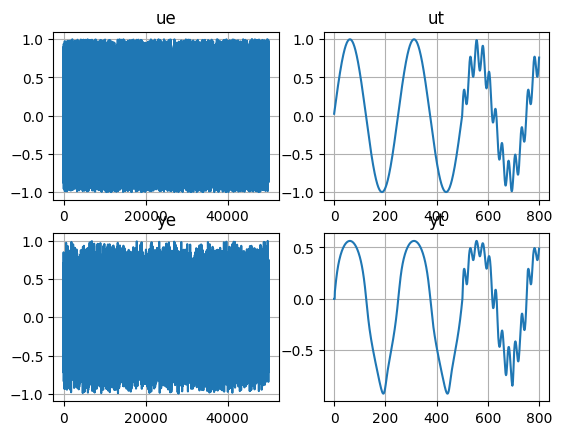

In [3]:
n_ue = int(5e4) # how many samples in the estimation dataset
n_uv = 800  # how many samples in the test       dataset

# ---- signal 1: sequence of random steps
min_U = -1
max_U = 1
B = 4 # how many constant samples
aux = min_U + (max_U-min_U) * np.random.rand(int(n_ue/B))
ue = np.repeat(aux, B, axis=0) # sequence of random steps with B samples each

# ---- signal 2: multi sine signal
# fsample = 1000 # sampling frequency (Hz)
# fmax = 100     # cutoff frequency (Hz)
# T = n_ue/fsample # total time (seconds)
# A = 1.2         # amplitude (whatever unit)
# ue = multiSine(fsample, fmax, T, A) # estimation all

# generate estimation data
ye = np.zeros(n_ue)
for k in range(3,n_ue):
    ye[k] = f_Narendra(ye[k-1],ye[k-2],ye[k-3],ue[k-1],ue[k-2])

# generate test data
k1 = np.arange(500)+1
k2 = np.arange(300)+501
ut = np.concatenate((  np.sin(2*np.pi*k1/250)   ,  0.8*np.sin(2*np.pi*k2/250)+0.2*np.sin(2*np.pi*k2/25)   ),axis=0)

yt = np.zeros(n_uv)

for k in range(3,n_uv):
    yt[k] = f_Narendra(yt[k-1],yt[k-2],yt[k-3],ut[k-1],ut[k-2])

plt.figure()
plt.subplot(221)
plt.plot(ue)
plt.title('ue')
plt.grid()
plt.subplot(222)
plt.plot(ut)
plt.title('ut')
plt.grid()
plt.subplot(223)
plt.plot(ye)
plt.title('ye')
plt.grid()
plt.subplot(224)
plt.plot(yt)
plt.title('yt')
plt.grid()
plt.show()


Create output and regression matrix

In [4]:
ny = 3
nu = 2 # model orders
(Ye,Phie) = matReg(ye,ue,ny,nu)
(Yt,Phit) = matReg(yt,ut,ny,nu)

In [14]:
Phie = torch.tensor(Phie, dtype=torch.float32)  # Replace with actual data
Ye = torch.tensor(Ye, dtype=torch.float32)      # Replace with actual data

# Create a dataset and dataloader
dataset = TensorDataset(Phie, Ye)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

<ipython-input-14-71968d436279>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Phie = torch.tensor(Phie, dtype=torch.float32)  # Replace with actual data
<ipython-input-14-71968d436279>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ye = torch.tensor(Ye, dtype=torch.float32)      # Replace with actual data


In [15]:
Phit = torch.tensor(Phit, dtype=torch.float32)  # Replace with actual data
Yt = torch.tensor(Yt, dtype=torch.float32)      # Replace with actual data

# Create a dataset and dataloader
dataset_test = TensorDataset(Phit, Yt)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

Define model architecture

In [22]:
class MyModel(nn.Module):
    def __init__(self, ninp, nneu, nout):
        super(MyModel, self).__init__()
        self.hidden1 = nn.Linear(ninp, nneu)
        self.hidden2 = nn.Linear(nneu, nneu)
        self.hidden3 = nn.Linear(nneu, nneu)
        self.output = nn.Linear(nneu, nout)

        # Initialize weights with LeCun Normal Initialization (equivalent to 'lecun_normal')
        nn.init.kaiming_normal_(self.hidden1.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.hidden2.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.hidden3.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='linear')

    def forward(self, x):
        x = F.selu(self.hidden1(x))
        x = F.selu(self.hidden2(x))
        x = F.selu(self.hidden3(x))
        x = self.output(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            return self.forward(x)

In [31]:
_ , ninp = Phie.shape
nout = 1
nneu = 80 # how many neurons per layer

# model definition
model = MyModel(ninp, nneu, nout)

# define optimizer and learning rate
optimizer = optim.NAdam(model.parameters(), lr=1e-3)

# define loss function
criterion = nn.MSELoss()


Finally train the model

In [32]:
# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss /= len(dataloader)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

print("Training finished!")

Epoch 1/3, Loss: 0.0024
Epoch 2/3, Loss: 0.0007
Epoch 3/3, Loss: 0.0005
Training finished!


Run one-step-ahead prediction

In [33]:
# One step ahead
y_train_pred1 = model.predict(Phie)
y_test_pred1  = model.predict(Phit)

R2test1  = r2_score(Yt, y_test_pred1)
R2train1 = r2_score(Ye, y_train_pred1)

print('-------------- One step ahead  --------------')
print('R2test1  =')
print(R2test1)
print('R2train1  =')
print(R2train1)

-------------- One step ahead  --------------
R2test1  =
0.9972985977932046
R2train1  =
0.9989208616544049


Run free-run simulation (prediction over prediction)

In [40]:

# Free Run
# y_train_pred0 = freeRun(model,ye,ue,ny,nu)
y_test_pred0  = freeRun(model,yt,ut,ny,nu)

# R2train0 = r2_score(Ye, y_train_pred0)
R2test0  = r2_score(Yt, y_test_pred0)

print('-------------- Free Run  --------------')
print('R2test0  =')
print(R2test0)
# print('R2train0  =')
# print(R2train0)

-------------- Free Run  --------------
R2test0  =
0.9956225049340666


Plot predictions

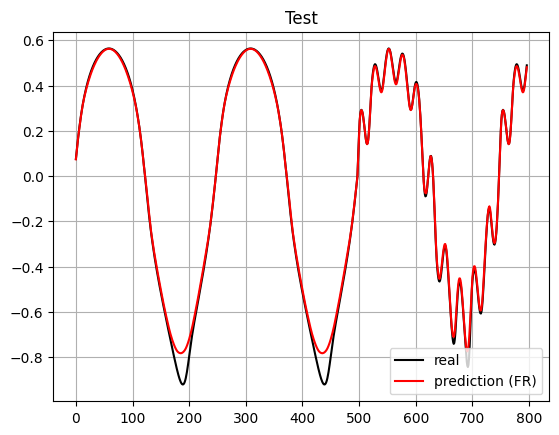

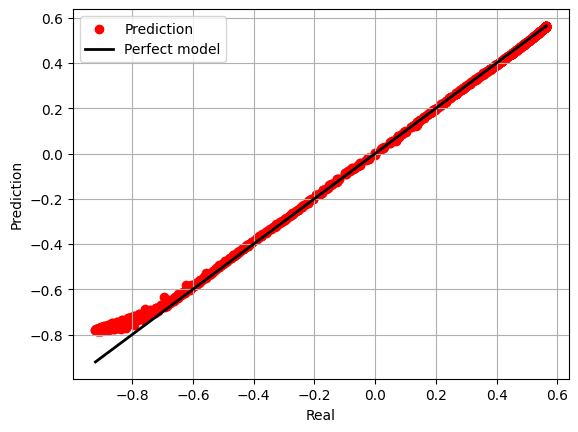

In [41]:
plt.figure()
# plt.subplot(211)
# plt.plot(Ye,'k',y_train_pred0,'r')
# plt.title('Estimation')
# plt.legend(('real','prediction (FR)'))
# plt.grid()
# plt.subplot(211)
plt.plot(Yt,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt),min(y_test_pred0))
maxY = max(max(Yt),max(y_test_pred0))
plt.scatter(Yt,y_test_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()